<a href="https://colab.research.google.com/github/Nikhil-Jakkani/image_sup_res/blob/main/image_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Enabling and testing the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import all the required libraries
import tensorflow as tf
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tensorflow.keras.utils import plot_model

In [ ]:
# Specify dataset directory
root_dir = './gdrive/My Drive/super_resolution/data'

In [ ]:
# Create training dataset
crop_size = 300 #image size scaled to 300x300
batch_size = 8
train_ds = image_dataset_from_directory(root_dir, batch_size=batch_size,
                                        image_size=(crop_size, crop_size),
                                        validation_split=0.2, subset="training",
                                        seed=1337, label_mode=None,)

Found 490 files belonging to 1 classes.
Using 392 files for training.


In [ ]:
# Create validation dataset
valid_ds = image_dataset_from_directory(root_dir, batch_size=batch_size,
                                        image_size=(crop_size, crop_size),
                                        validation_split=0.2, subset="validation",
                                        seed=1337, label_mode=None,)

Found 490 files belonging to 1 classes.
Using 98 files for validation.


In [ ]:
# Rescale the images to take values in the range [0, 1]
def scaling(input_image):
    input_image = input_image / 255.0 # 255/255 -> 1 (Max), 0/255 --> 0 (Min)
    return input_image
# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

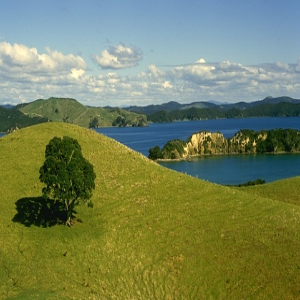

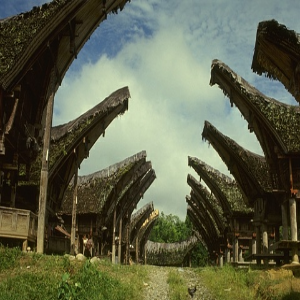

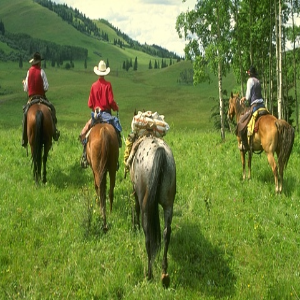

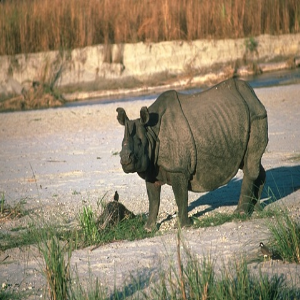

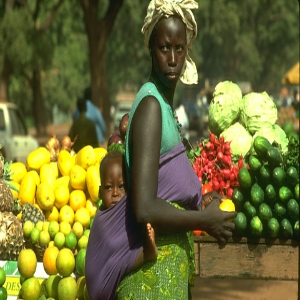

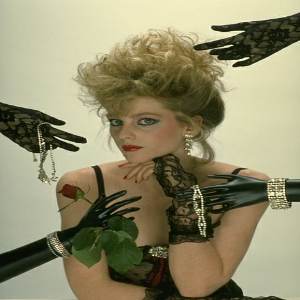

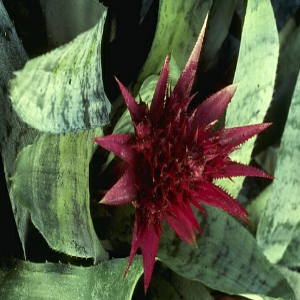

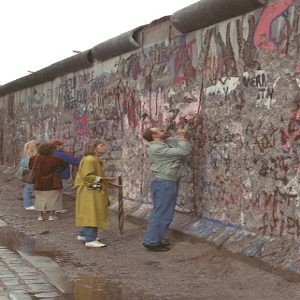

In [ ]:
# Visualize a few sample images:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [ ]:
# Crop and resize images
upscale_factor = 3
input_size = crop_size // upscale_factor
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")
def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y
train_ds = train_ds.map(lambda x: (process_input(x, input_size, upscale_factor),
                                   process_target(x)))
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.map(lambda x: (process_input(x, input_size, upscale_factor),
                                   process_target(x)))
valid_ds = valid_ds.prefetch(buffer_size=32)

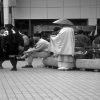

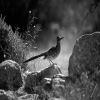

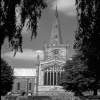

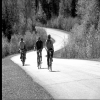

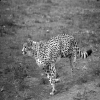

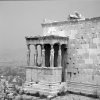

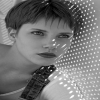

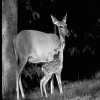

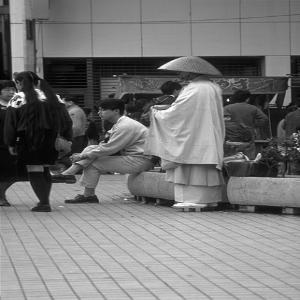

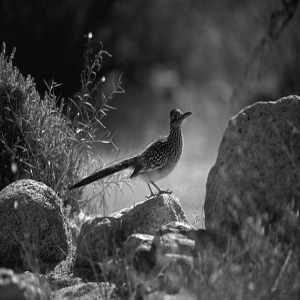

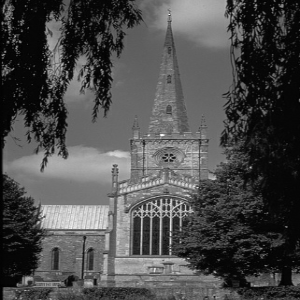

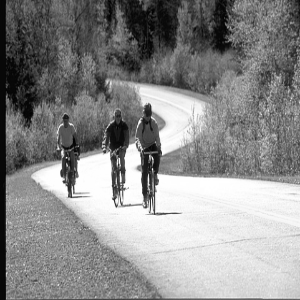

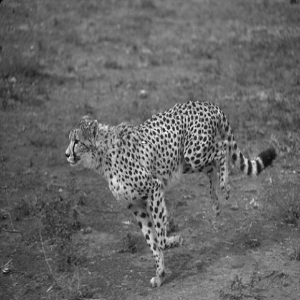

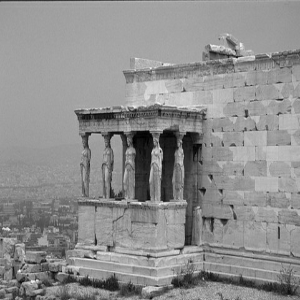

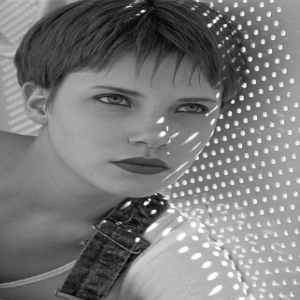

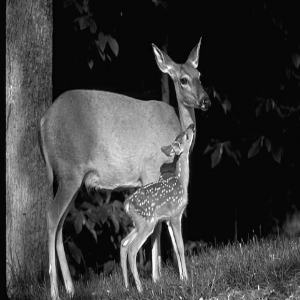

In [ ]:
# Look at the input and target data
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [ ]:
# Build a model
def get_model(upscale_factor=3, channels=1):
    conv_args = {"activation": "relu", "kernel_initializer": "Orthogonal",
                 "padding": "same",}
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)
    return keras.Model(inputs, outputs)

In [ ]:
# Define utility functions
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0
    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")
    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")
    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)
    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize((img.size[0] // upscale_factor, img.size[1] // upscale_factor),
                      PIL.Image.BICUBIC,)

def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0
    input = np.expand_dims(y, axis=0)
    out = model.predict(input)
    out_img_y = out[0]
    out_img_y *= 255.0
    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr",(out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img

In [ ]:
# Compute Peak Signal to Noise Ratio (PSNR)
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)
    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []
    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")
    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
# Prepare a dataset of test image paths
test_path= './gdrive/My Drive/super_resolution/test'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)
print('Number of images in test folder: {} \n'.format(len(test_img_paths)))

Number of images in test folder: 5 



In [ ]:
print(test_img_paths[0])

./gdrive/My Drive/super_resolution/test/130014.jpg


In [ ]:
# Define callbacks to monitor training
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_filepath = "./gdrive/My Drive/super_resolution/super_weights.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                            save_weights_only=True,
                                                            monitor="loss", mode="min",
                                                            save_best_only=True,)
callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]

In [ ]:
# Display the model architecture
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOp  (None, None, None, 1)     0         
 Lambda)                                                         
                                                             

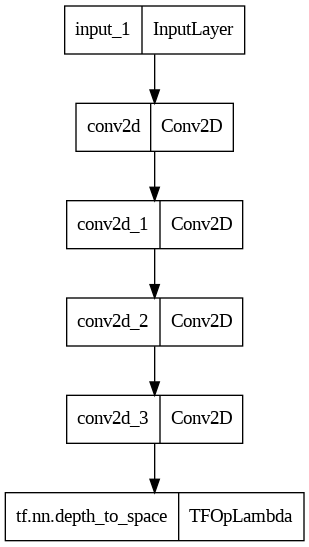

In [ ]:
# Display the model architecture
plot_model(model, to_file='model.png')

In [ ]:
# Model Compilation
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn,)

Epoch 1/100
Mean PSNR for epoch: 21.85
1/1 [==============================] - 0s 392ms/step


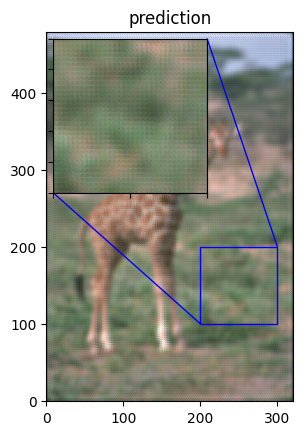

49/49 - 9s - loss: 0.0399 - val_loss: 0.0070 - 9s/epoch - 188ms/step
Epoch 2/100
Mean PSNR for epoch: 24.87
49/49 - 5s - loss: 0.0050 - val_loss: 0.0035 - 5s/epoch - 93ms/step
Epoch 3/100
Mean PSNR for epoch: 25.52
49/49 - 5s - loss: 0.0033 - val_loss: 0.0029 - 5s/epoch - 98ms/step
Epoch 4/100
Mean PSNR for epoch: 25.77
49/49 - 4s - loss: 0.0031 - val_loss: 0.0028 - 4s/epoch - 84ms/step
Epoch 5/100
Mean PSNR for epoch: 25.42
49/49 - 3s - loss: 0.0029 - val_loss: 0.0027 - 3s/epoch - 54ms/step
Epoch 6/100
Mean PSNR for epoch: 25.52
49/49 - 3s - loss: 0.0028 - val_loss: 0.0026 - 3s/epoch - 53ms/step
Epoch 7/100
Mean PSNR for epoch: 25.50
49/49 - 3s - loss: 0.0028 - val_loss: 0.0028 - 3s/epoch - 53ms/step
Epoch 8/100
Mean PSNR for epoch: 26.15
49/49 - 4s - loss: 0.0027 - val_loss: 0.0026 - 4s/epoch - 80ms/step
Epoch 9/100
Mean PSNR for epoch: 25.86
49/49 - 2s - loss: 0.0027 - val_loss: 0.0026 - 2s/epoch - 50ms/step
Epoch 10/100
Mean PSNR for epoch: 25.99
49/49 - 2s - loss: 0.0028 - val_los

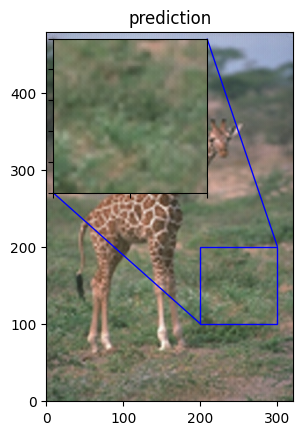

49/49 - 3s - loss: 0.0027 - val_loss: 0.0029 - 3s/epoch - 62ms/step
Epoch 22/100
Mean PSNR for epoch: 25.93
49/49 - 4s - loss: 0.0030 - val_loss: 0.0025 - 4s/epoch - 79ms/step
Epoch 23/100
Mean PSNR for epoch: 26.20
49/49 - 3s - loss: 0.0026 - val_loss: 0.0024 - 3s/epoch - 64ms/step
Epoch 24/100
Mean PSNR for epoch: 26.43
49/49 - 3s - loss: 0.0026 - val_loss: 0.0024 - 3s/epoch - 53ms/step
Epoch 25/100
Mean PSNR for epoch: 25.93
49/49 - 3s - loss: 0.0026 - val_loss: 0.0024 - 3s/epoch - 71ms/step
Epoch 26/100
Mean PSNR for epoch: 25.93
49/49 - 2s - loss: 0.0026 - val_loss: 0.0024 - 2s/epoch - 50ms/step
Epoch 27/100
Mean PSNR for epoch: 26.12
49/49 - 2s - loss: 0.0026 - val_loss: 0.0024 - 2s/epoch - 49ms/step
Epoch 28/100
Mean PSNR for epoch: 26.46
49/49 - 3s - loss: 0.0025 - val_loss: 0.0024 - 3s/epoch - 53ms/step
Epoch 29/100
Mean PSNR for epoch: 26.37
49/49 - 5s - loss: 0.0025 - val_loss: 0.0024 - 5s/epoch - 105ms/step
Epoch 30/100
Mean PSNR for epoch: 26.08
49/49 - 3s - loss: 0.0025 -

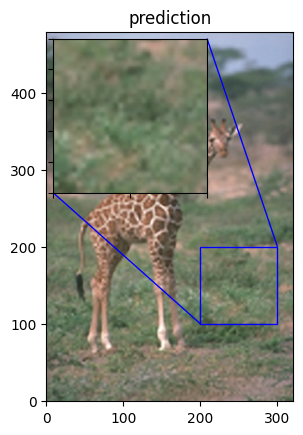

49/49 - 3s - loss: 0.0025 - val_loss: 0.0024 - 3s/epoch - 66ms/step
Epoch 42/100
Mean PSNR for epoch: 26.25
49/49 - 4s - loss: 0.0025 - val_loss: 0.0024 - 4s/epoch - 78ms/step
Epoch 43/100
Mean PSNR for epoch: 25.93
49/49 - 3s - loss: 0.0026 - val_loss: 0.0024 - 3s/epoch - 53ms/step
Epoch 44/100
Mean PSNR for epoch: 25.42
49/49 - 2s - loss: 0.0026 - val_loss: 0.0024 - 2s/epoch - 49ms/step
Epoch 45/100
Mean PSNR for epoch: 26.42
49/49 - 3s - loss: 0.0025 - val_loss: 0.0024 - 3s/epoch - 51ms/step
Epoch 46/100
Mean PSNR for epoch: 26.13
49/49 - 4s - loss: 0.0025 - val_loss: 0.0024 - 4s/epoch - 78ms/step
Epoch 47/100
Mean PSNR for epoch: 26.08
49/49 - 3s - loss: 0.0025 - val_loss: 0.0024 - 3s/epoch - 52ms/step
Epoch 48/100
Mean PSNR for epoch: 26.40
49/49 - 2s - loss: 0.0025 - val_loss: 0.0024 - 2s/epoch - 50ms/step
Epoch 49/100
Mean PSNR for epoch: 26.34
49/49 - 2s - loss: 0.0025 - val_loss: 0.0024 - 2s/epoch - 49ms/step
Epoch 50/100
Mean PSNR for epoch: 26.30
49/49 - 3s - loss: 0.0025 - 

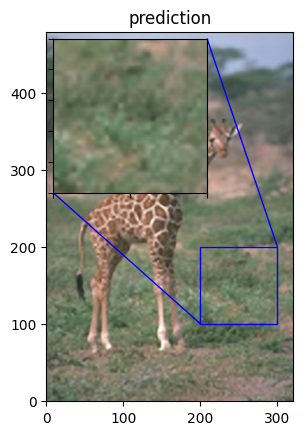

49/49 - 4s - loss: 0.0025 - val_loss: 0.0023 - 4s/epoch - 88ms/step
Epoch 62/100
Mean PSNR for epoch: 26.36
49/49 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 53ms/step
Epoch 63/100
Mean PSNR for epoch: 26.11
49/49 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 52ms/step
Epoch 64/100
Mean PSNR for epoch: 26.80
49/49 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 54ms/step
Epoch 65/100
Mean PSNR for epoch: 26.27
49/49 - 4s - loss: 0.0025 - val_loss: 0.0023 - 4s/epoch - 77ms/step
Epoch 66/100
Mean PSNR for epoch: 26.26
49/49 - 2s - loss: 0.0025 - val_loss: 0.0024 - 2s/epoch - 49ms/step
Epoch 67/100
Mean PSNR for epoch: 26.07
49/49 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 61ms/step
Epoch 68/100
Mean PSNR for epoch: 26.37
49/49 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 51ms/step
Epoch 69/100
Mean PSNR for epoch: 26.75
49/49 - 4s - loss: 0.0025 - val_loss: 0.0023 - 4s/epoch - 72ms/step
Epoch 70/100
Mean PSNR for epoch: 26.24
49/49 - 2s - loss: 0.0025 - 

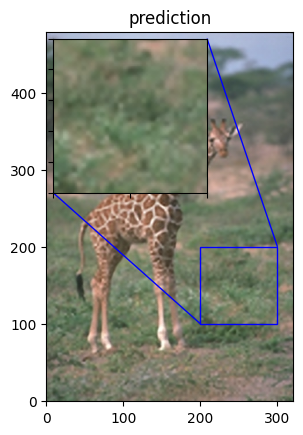

49/49 - 3s - loss: 0.0024 - val_loss: 0.0023 - 3s/epoch - 65ms/step
Epoch 82/100
Mean PSNR for epoch: 26.61
49/49 - 4s - loss: 0.0024 - val_loss: 0.0023 - 4s/epoch - 73ms/step
Epoch 83/100
Mean PSNR for epoch: 27.04
49/49 - 2s - loss: 0.0024 - val_loss: 0.0023 - 2s/epoch - 51ms/step
Epoch 84/100
Mean PSNR for epoch: 26.86
49/49 - 3s - loss: 0.0024 - val_loss: 0.0023 - 3s/epoch - 63ms/step
Epoch 85/100
Mean PSNR for epoch: 26.28
49/49 - 3s - loss: 0.0024 - val_loss: 0.0024 - 3s/epoch - 52ms/step
Epoch 86/100
Mean PSNR for epoch: 26.54
49/49 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 50ms/step
Epoch 87/100
Mean PSNR for epoch: 26.41
49/49 - 2s - loss: 0.0024 - val_loss: 0.0023 - 2s/epoch - 50ms/step
Epoch 88/100
Mean PSNR for epoch: 26.18
49/49 - 3s - loss: 0.0024 - val_loss: 0.0023 - 3s/epoch - 68ms/step
Epoch 89/100
Mean PSNR for epoch: 26.71
49/49 - 3s - loss: 0.0025 - val_loss: 0.0023 - 3s/epoch - 54ms/step
Epoch 90/100
Mean PSNR for epoch: 26.76
49/49 - 3s - loss: 0.0024 - 

In [ ]:
# Train the model
epochs = 100
model.fit(train_ds, epochs=epochs, callbacks=callbacks,
          validation_data=valid_ds, verbose=2)

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights("./gdrive/My Drive/super_resolution/super_weights.h5")

1/1 [==============================] - 0s 15ms/step
PSNR of low resolution image and high resolution image is 26.8509
PSNR of predict and high resolution is 27.2290


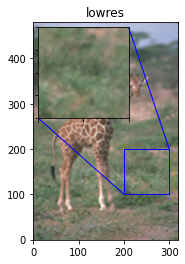

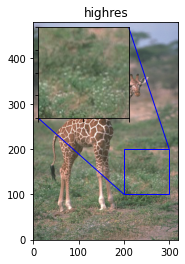

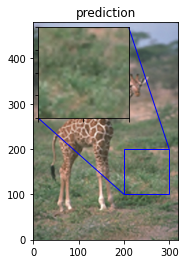

1/1 [==============================] - 0s 295ms/step
PSNR of low resolution image and high resolution image is 23.1739
PSNR of predict and high resolution is 23.6372


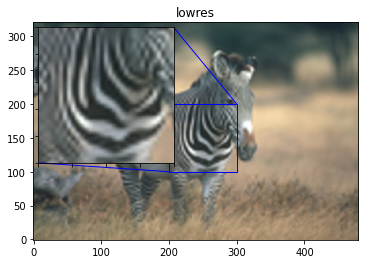

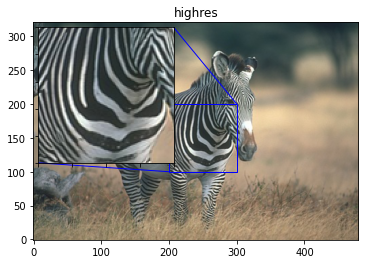

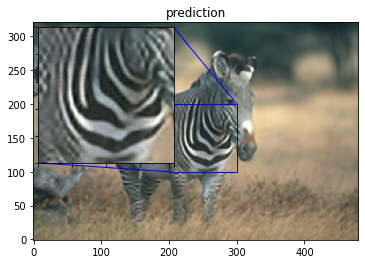

1/1 [==============================] - 0s 15ms/step
PSNR of low resolution image and high resolution image is 23.9184
PSNR of predict and high resolution is 24.6450


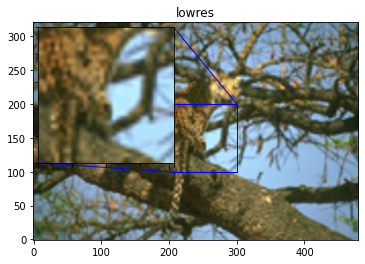

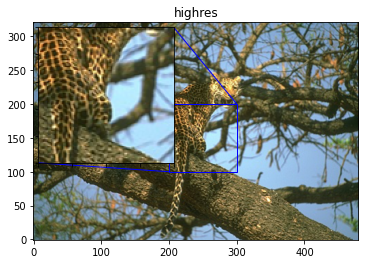

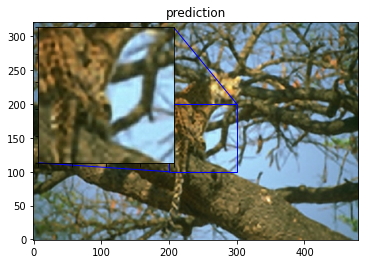

1/1 [==============================] - 0s 17ms/step
PSNR of low resolution image and high resolution image is 19.6810
PSNR of predict and high resolution is 20.4938


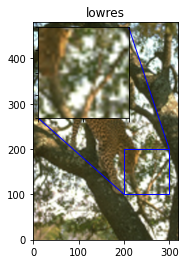

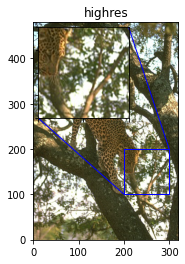

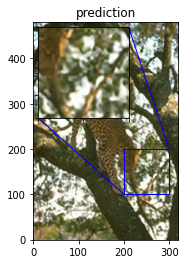

1/1 [==============================] - 0s 15ms/step
PSNR of low resolution image and high resolution image is 21.9219
PSNR of predict and high resolution is 22.4948


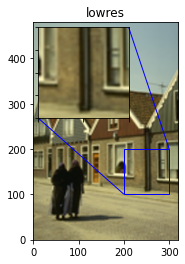

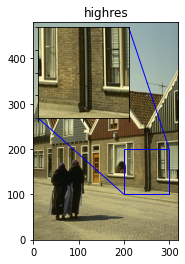

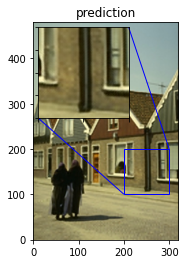

Avg. PSNR of lowres images is 11.5546
Avg. PSNR of reconstructions is 11.8500


In [ ]:
# Model prediction and plot the results
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
for index, test_img_path in enumerate(test_img_paths[0:len(test_img_paths)]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)
    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [ ]:
# Prepare a dataset of custom prediction image paths
predict_path = './gdrive/My Drive/super_resolution/prediction'
predict_img_paths = sorted(
    [
        os.path.join(predict_path, fname)
        for fname in os.listdir(predict_path)
        if fname.endswith(".jpg")
    ]
)
print('Number of images in prediction folder: {} \n'.format(len(predict_img_paths)))

Number of images in prediction folder: 5 



In [ ]:
# Define plot function
def plot_result(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0
    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")
    plt.title(title)
    plt.show()

In [ ]:
# Super resolution of custom image
for index, predict_img_path in enumerate(predict_img_paths[0:len(predict_img_paths)]):
    img = load_img(predict_img_path)
    prediction = upscale_image(model, img)
    predict_img_arr = img_to_array(prediction)
    plot_result(img, index, "original")
    plot_result(prediction, index, "prediction")
    print(len(predict_img_paths))

NameError: ignored